In [129]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline

In [130]:
def correct(x):
    """Function to correct for round-off errors to 7 
       decimal places.
       
       Args:
       -----
       x    : an ndarray.
       
       Returns:
       --------
       y    : an ndarray correction of x.
    """
#   Tolarance:
    tol = 1.0e-07
    sign = np.sign(x)
    y = np.abs(x)
    
#   correct for precision:
    for i in np.arange(np.size(x)):
        if np.abs(y[i] - 1.0) < tol:
            y[i] = 1.0
        elif np.abs(y[i] - 0.0) < tol:
            y[i] = 0.0

    return y * sign
######################## simple test #################
#if __name__ == "__main__":
#    x = [1e-8, 1e-5]
#    print correct(x)

In [131]:
def mapphi(alpha, beta, phi):
    """Function to map the rotational axis:
       
       Args:
       -----
       alpha       : magnetic inclination angle w.r.t the rotatinal axis (degrees)
       beta        : line of sight closest approach to the magnetic axis (degrees)
       
       Returns:
       --------
       xlos, ylos  : The coordinates of the rotatinal plane; both the size of phi.
       
    """
    cosR = np.cos(np.deg2rad(alpha+beta)) * np.cos(np.deg2rad(alpha))
    cosR += np.sin(np.deg2rad(alpha+beta)) * np.sin(np.deg2rad(alpha)) * np.cos(np.deg2rad(phi))

    R = np.arccos(correct(cosR))

    # problems with precision for 180 degrees
    cosgamma = np.zeros_like(R)

    for i in np.arange(len(R)):
        if int(R[i]*100.0) == 180.0:
            R[i] = int(R[i]*100.0)/100.0
        if R[i] != 0.0 and R[i] != 180.0 and alpha > 0.0:
            cosgamma[i] = (np.cos(np.deg2rad(alpha+beta)) - np.cos(np.deg2rad(alpha)) * cosR[i]) \
                  /(np.sin(np.deg2rad(alpha)) * np.sin(R[i]))
        else:
             cosgamma[i] = 0.0

    cosgamma_corr = correct(cosgamma)
    gamma = np.arccos(cosgamma_corr)
    xp = R * np.sin(gamma)
    
    for i in np.arange(len(phi)):
        if phi[i] > 0.0:
            xp[i] = -xp[i]

    yp = -R * np.cos(gamma)
     
    return xp, yp
#############################################
if __name__ == "__main__":
    phi= np.linspace(-180, 180, num=500, endpoint=True)
    alpha = 10
    beta = 3
    xlos, ylos =  mapphi(alpha, beta, phi)


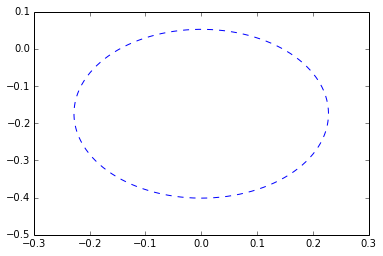

In [132]:
def los(alpha, beta):
    """Function to determine the line of sight cut across the beam.
    
       Args:
       -----
       alpha       : inclination angle
       beta        : impact parameter
       
       Returns:
       --------
       xlos        : the line of sight x-coordinates
       ylos        : the line of sight y-coordinates
       thetalos : the line of sight angle in degrees
    """

#   rotational phase:
    phi = np.linspace(-180, 180, num=500, endpoint=True)
    
#   line of sight x,y plane:
    xlos, ylos = mapphi(alpha, beta, phi)
    thetalos = np.arctan2(ylos, xlos) * (180 / np.pi) - 90.0
    for i in np.arange(len(thetalos)):
        if thetalos[i] < 0:
            thetalos[i] = -thetalos[i]       
            
    return xlos, ylos, thetalos
################## test ######################
if __name__ == "__main__":
    xlos, ylos, thetalos = los(alpha, beta)
    plt.plot(xlos, ylos, 'b--')

In [133]:
def emission_height(P, hmin, hmax, ncomp):
    """Function to determine emission heights given hmin and hmax. Allowed emision heights for young 
       pulsars range between [950, 1000] and between [20, 1000] for old pulsars.
    
       Args:
       -----
       P      : rotational period.
       hmin   : minimum emission height (in km).
       hmax   : maximum emission height (in km).
       ncomp  : integer number of component .
       
       Returns:
       --------
       H      : random emission height.
    """
    
#   num_H = np.random.randint(3,8), number of discrete emission height 
    num_H = ncomp
    
#   emission height for a short period pulsar: only one emission height 
    if P <= 0.15:
        if hmin >= 950 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=1)
            
        else: print "error, emission range not allowed for pulse period P < 0.15 seconds"
            
#   emission height for a long period pulsar:        
    if P > 0.15:
        if hmin >= 20 and hmax <= 1000:
            H = np.random.uniform(hmin, hmax, size=num_H)
        
        else: print "error, emission range not allowed for pulse period P > 0.15 seconds"
        
    return H

########################### simple test #############################
if __name__ == "__main__":
    P = 0.16
    hmin = 50
    hmax = 1000
    ncomp = 6
    heights = emission_height(P, hmin, hmax, ncomp)
    print "heigths = ",heights,"km"  

heigths =  [ 960.20650758  868.86616124  432.92050345  502.25850999   62.31312203
  664.53362861] km


In [134]:
from scipy import constants
#import emission_height

def rho(P, heights):
    """Function to determine the opening angle rho given the rotational period and emission height.
       
    
       Args:
       -----
       P         : rotational period (seconds)
       heights   : emission heights (km)
       
       Returns:
       --------
       rho       : the opening angle (degrees)
       
    """

#   opening angle (eqn 3.29, Lorimer and Kramer 2005):
    rho = np.rad2deg(np.sqrt((9 * np.pi * heights) / (2 * (constants.c / 1000) * P)))   
    
    return rho

#################### simple test #####################################
if __name__ == "__main__":
    opa = rho(P, heights)
    print "opening angle =",opa,"degrees"

opening angle = [ 30.48005914  28.99411951  20.46621633  22.04434173   7.76467421
  25.35665516] degrees


In [135]:
def patch_width(P, heights):
    """Function to calculate the width of a patchy emission region 
       within a pulsar beam at a given height.
    
       Args:
       -----
       P             : rotational period (seconds).
       heights       : emission heights (km).
      
       
       Returns:
       --------
       patchwidths   : the width of the patchy emission region (degrees).
       
    """   
    
#   width of the patch (eqn 3, KJ2007):
    patchwidths = 2.45 * 0.2 * np.sqrt(heights / ( 10 * P)) 
    
    return patchwidths
#################### simple test ################################################
if __name__ == "__main__":
    patchwidths = patch_width(P, heights)
    print "patch width =",patchwidths,"degrees"


patch width = [ 12.00379061  11.41859135   8.0600951    8.68159937   3.05791806
   9.98606918] degrees


In [136]:
def patch_center(P, heights):
    """Function find centres of the patches
       
       Args:
       -----
       P       : rotatinal period
       heights : emission heights (in km).
       
       
       Returns:
       --------
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
    """
    
#   opening angle:    
    opa = rho(P, heights) 
    
#   initialize the array:
    centerx = []
    centery = []
    
    for comp in opa: #for each emission height (comp!)
#       number of active patches (table 2, KJ2007): 
        npatch = np.random.randint(2,10+1)
        tempCenterX = []
        tempCenterY = []
        theta = 2 * np.pi * np.random.random(npatch)

#       centers for short periods:
        if P <= 0.15:
            if hmin >= 950 and hmax <= 1000:
                for i in np.arange(npatch):
                    tempCenterX.append(comp * np.sin(theta[i]))
                    tempCenterY.append(comp * np.cos(theta[i]))
                
#       centers for longer periods:
        if P > 0.15:
            if hmin >= 20 and hmax <= 1000:
                for i in np.arange(npatch):
                    tempCenterX.append(comp * np.sin(theta[i]))
                    tempCenterY.append(comp * np.cos(theta[i]))
        centerx.append(tempCenterX)
        centery.append(tempCenterY)
        
        print "acive patches: " ,npatch
        
    return centerx, centery

########################### simple test ###########################
if __name__ == "__main__":
    cx, cy = patch_center(P, heights)
    for i in range(len(cx)):
        print 'height %i:\n'%i, cx[i], '\n', cy[i], '\n'

acive patches:  6
acive patches:  6
acive patches:  9
acive patches:  5
acive patches:  6
acive patches:  10
height 0:
[29.141618839622474, -30.471660462662971, -22.807618664036102, 23.230739244445367, 30.472676679298452, -5.1913273551803805] 
[-8.9330877447841779, 0.71548158469321821, -20.219953910080132, -19.732378452848476, 0.67080641677992991, 30.034715339773218] 

height 1:
[-20.140753106939226, -9.8008511711839841, 28.051170519948936, -27.797464604075362, 8.7875744527803743, 2.8938718254059999] 
[-20.856870097765583, -27.287401530927266, 7.3342210527429623, 8.2437811455015897, -27.630372802888346, -28.849340925710443] 

height 2:
[13.788280681290766, -6.8482510492675273, 5.909795489354134, 20.259140384555636, 10.559439954493241, -18.912827457549721, 8.5222168337455173, -3.2431747606921588, 18.857144297299207] 
[15.124461198694528, -19.286458157553934, -19.594395320368577, -2.9040044035330697, 17.531806482628205, 7.8211871386526681, 18.607467074685285, -20.207618072610185, 7.95450

In [137]:
def scatter(prof,dm,period,freq):
    """
    Function to perform convolution for a scattered profile. If dm = 0, the function
    returns the input profile without convolution. 
    
    Args:
    -----

        prof   : an array of the profile
        dm     : dispersion measure in cm^-3 pc.
        period : rotational period in seconds.
        freq   : observing frequency in GHz.

    Returns:
    --------

        conv   : convolution of the profile.

    """

    if dm != 0:
        
        #npts = float(prof.shape[0])
        npts = float(len(prof))
        tbin = (period * 1000) / npts    # tbin = time of each bin in ms.
        log_tau = -6.46 + 0.154 * np.log10(dm) + 1.07 * (np.log10(dm))**2 - 3.86 * np.log10(freq)
#       tau = scattering time scale as in Bhat et al. (2004) in ms.
        tau = 10**log_tau
        tcrit = -tau / np.log(0.01)
        bincrit = tcrit / tbin

        verbose = raw_input('verbose (y/n)? : ')
        if verbose is 'y':
            print "Scattering for tau = " + str(tau) + ", dm = " + str(dm) + \
            ", period = " + str(period) + ", freq = " + str(freq) + ", tbin = " + str(tbin)
        

        if bincrit > 10 * npts: bincrit = 10 * npts

        if bincrit < npts: bincrit = npts

        if verbose is 'y': print "Critical bin: " + str(bincrit)
        
#       Convolution:
#       1. Transpose the profile:
        
        tprof = prof[::-1]

#       2. Slide along the time axis for as long as the scatter response is still high enough
#          (tb = straight bin number, tbf = folded bin number)
        tb = 0
        tbf = 0
        
        conv = np.zeros(int(npts))
        #scr = np.zeros(int(npts))
        while tb < bincrit + npts - 1:

            #print tbf, conv.shape, npts, bincrit+npts-1
            #the loops slows down the program
            for i in np.arange(int(npts) - 1):
               
                if tb + i - 1 > npts:
                    frac = (tb + i - 1 - npts) * tbin / tau
                    scr = np.exp(-frac)
                else: 
                    scr = 0.0
                
                if scr != 0.0:
                    #conv[tbf] = tprof[i] * scr[i]
                    conv[tbf] += tprof[i] * scr
                else: conv[tbf] += tprof[i]

            tb += 1
            tbf += 1
            if tbf > int(npts) - 1: tbf=1 
       
    
    if dm == 0.: 
        print('No scattering for dm == 0; returning the profile without convolution!')
        conv = prof 
    return conv

###############################################################################################
#simple test statement

if __name__ == "__main__":
    prof = np.arange(200)
    dm = 200
    period = 0.5
    freq = 0.3
    scr = scatter(prof, dm, period, freq)

verbose (y/n)? : y
Scattering for tau = 37.8478618603, dm = 200, period = 0.5, freq = 0.3, tbin = 2.5
Critical bin: 200.0


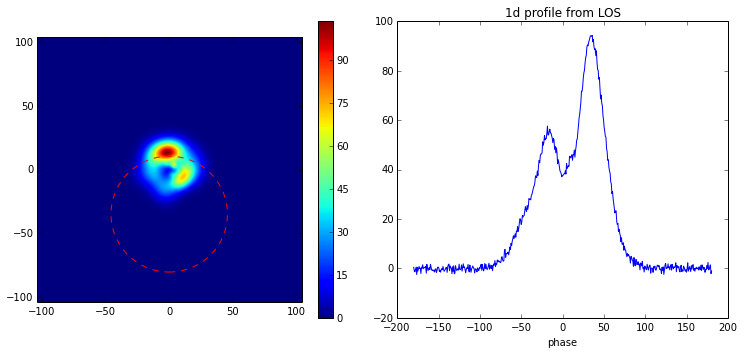

In [138]:
#import d2r
def plotpatch(P, alpha, beta, heights, centerx, centery):
    """Function to plot the patches for a given height range. Using a 2d gaussian
    
       Args:
       -----
       P       : rotational period (seconds)
       alpha   : inclination angle (degrees)
       beta    : impact parameter (degrees)
       heights : emission heights (in km)
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
       
       Returns:
       --------
       A plot of the patches projected on to observational plane.
    
    """    
    
#   initialize parameters:
    xmin = -180.
    xmax = 180.
    xnum = 500
    ymin = -180.
    ymax = 180.
    ynum = 500
    dx = (xmax - xmin)/xnum
    dy = (ymax - ymin)/ynum
    x = np.linspace(xmin, xmax, num=xnum, endpoint=True)
    y = np.linspace(ymin, ymax, num=ynum, endpoint=True)
    X,Y = np.meshgrid(x,y)
    gauss = np.zeros(len(x))
    Z = np.zeros_like(X)
    prof_los = np.zeros_like(gauss)

#   find the width of the patches:
    patchwidths = patch_width(P, heights)
      
    
#   An arbitrary peak of the profile:
    peak = 10. 
    
#   Get the line of sight:
    xlos, ylos, thetalos = los(alpha, beta)

    for cid, comp in enumerate(heights):
#       widths for circular patches:        
        sigmax = patchwidths[cid]
        sigmay = patchwidths[cid]
    
#       center of the patch:
        patchCenterX = centerx[cid]
        patchCenterY = centery[cid]
        
#       1D gassian profile:
        for cen in np.arange(len(patchCenterX)):
            gauss += peak * np.exp(-((x - patchCenterX[0]) / sigmax)**2)
        
#       2D patch:
        for pc in zip(patchCenterX, patchCenterY):
            Z += peak * np.exp(-((X - pc[0])**2 / (2 * sigmax**2) + (Y - pc[1])**2 / (2 * sigmay**2)))
            
#   1D profile from 2D patch, closest to the line of sight (select nearest neighbors):
    temp = 200
    ZxIdx = np.array(temp*xlos/dx, dtype=int) - int(xnum/2) # x index
    ZyIdx = np.array(temp*ylos/dy, dtype=int) - int(ynum/2) # y index
    prof = Z[ZxIdx, ZyIdx]
    
#   add noise: a normal distibution with zero mean, and std dev = 1
    noise = np.random.normal(0, 1, 500)
    gauss = gauss + noise
    prof = prof + noise
    #plt.plot(noise)
    
    
#   profile plot:

    #gauss = gauss - xlos
    #fig1 = plt.figure(figsize=(10,5))
    #ax1 = plt.subplot(1, 2, 1)
    #plt.title("1d profile")
    #plt.xlabel("phase")
    #plt.tight_layout()
    #plt.plot(x, gauss)
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.title("1d profile from LOS")
    plt.xlabel("phase")
    plt.tight_layout()
    plt.plot(x, prof)
    
#   scattered profile:
#    prof_scatter = scatter(prof, dm, period,freq)
#    plt.figure()
#    plt.title("scattered profile")
#    plt.xlabel("phase")
#    plt.plot(x, prof_scatter)
    
#   patchy emission region:

    plt.subplot(1, 2, 1)
    plt.plot(temp*xlos, temp*ylos, '--r')
    plt.imshow(Z, extent=[-np.amax(Z),np.amax(Z),-np.amax(Z),np.amax(Z)])#, cmap=cm.gray)
    #plt.imshow(Z, extent=[xmin,xmax,ymin,ymax])
    plt.colorbar()
    

    

############################ simple test ##########################
if __name__ == "__main__":
    plotpatch(P, alpha, beta, heights, cx, cy)